$f_{0}$ extraction using the Pitch Tracking Dataset from TU Graz (PTDBUG)

At first, import packages to be used for the experiments

In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import os
import glob
import numpy as np
from tqdm import tqdm
import time
import librosa
import pandas as pd
import seaborn as sns

from joblib import dump, load

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import make_scorer, zero_one_loss
from pyrcn.metrics import mean_squared_error
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.util import FeatureExtractor
from pyrcn.datasets import fetch_ptdb_tug_dataset
from pyrcn.echo_state_network import SeqToSeqESNRegressor
from pyrcn.base import InputToNode, PredefinedWeightsInputToNode, NodeToNode
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex': True,
          'font.size': 8,
          'font.family': 'lmodern',
         }
plt.rcParams.update(params)
mpl.rc('font', **{'family': 'serif'})
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable

import librosa

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


Print number of files that are included in the dataset

In [2]:
def create_feature_extraction_pipeline(sr=16000):
    audio_loading = Pipeline([("load_audio", FeatureExtractor(func=librosa.load, kw_args={"sr": sr, "mono": True})),
                              ("normalize", FeatureExtractor(func=librosa.util.normalize, kw_args={"norm": np.inf}))])
    
    feature_extractor = Pipeline([("mel_spectrogram", FeatureExtractor(func=librosa.feature.melspectrogram, 
                                                                       kw_args={"sr": sr, "n_fft": 1024, "hop_length": 80, 
                                                                                "window": 'hann', "center": False, 
                                                                                "power": 2.0, "n_mels": 80, "fmin": 40, 
                                                                                "fmax": 4000, "htk": True})),
                                            ("power_to_db", FeatureExtractor(func=librosa.power_to_db, kw_args={"ref": 1}))])

    feature_extraction_pipeline = Pipeline([("audio_loading", audio_loading),
                                            ("feature_extractor", feature_extractor)])
    return feature_extraction_pipeline

## Load and preprocess the dataset

This might require a large amount of time and memory. 

In [3]:
# Load and preprocess the dataset
feature_extraction_pipeline = create_feature_extraction_pipeline()

X_train, X_test, y_train, y_test = fetch_ptdb_tug_dataset(data_origin="Z:/Projekt-Pitch-Datenbank/SPEECH_DATA", 
                                                          data_home=None, preprocessor=feature_extraction_pipeline, 
                                                          force_preprocessing=False, augment=0)

Feature visualization. All features carry information, since the variance is always large

We can fit a StandardScaler here!

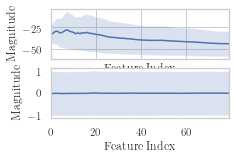

In [4]:
def tsplot(ax, data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(3.2, 2)
tsplot(axs[0], np.concatenate(np.hstack((X_train, X_test))))
axs[0].set_xlabel('Feature Index')
axs[0].set_ylabel('Magnitude')
scaler = StandardScaler().fit(np.concatenate(X_train))
for k, X in enumerate(X_train):
    X_train[k] = scaler.transform(X=X)
for k, X in enumerate(X_test):
    X_test[k] = scaler.transform(X=X)
tsplot(axs[1], np.concatenate(np.hstack((X_train, X_test))))
axs[1].set_xlabel('Feature Index')
axs[1].set_ylabel('Magnitude')
plt.grid()
# plt.savefig('features_statistics.pdf', bbox_inches='tight', pad_inches=0)

In [5]:
all_y_train = []
for k in range(0, 1):
    print(k)
    all_y_train.append(np.vstack((np.concatenate(y_train), np.concatenate(y_test)))[:, 0] * 2**(k/12))
all_y_test = []
for k in range(0, 1):
    print(k)
    all_y_test.append(np.concatenate(y_test)[:, 0] * 2**(k/12))

all_y_train = np.concatenate(all_y_train)
all_y_test = np.concatenate(all_y_test)

0
0


In [6]:
np.min(all_y_test[all_y_test!=0])

53.3364486694

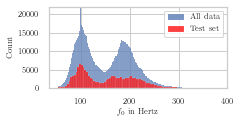

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.5)
sns.histplot(x=all_y_train[all_y_train!=0], stat="count", label="All data", ax=ax)  # , log_scale=True
sns.histplot(x=all_y_test[all_y_test!=0], stat="count", label="Test set", color="red", ax=ax)  # , log_scale=True
plt.xlabel(r"$f_{0}$ in Hertz", fontsize=8)
plt.ylabel(r"Count", fontsize=8)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([50, 100, 200, 400])
ax.set_xlim([35, 400])
ax.set_ylim([0, 22000])
ax.tick_params(labelsize=8)
plt.minorticks_off()
plt.legend(prop={'size': 8})
plt.savefig('ptdb_tug_ground_truth.pdf', bbox_inches='tight', pad_inches=0)

Define several error functions for $f_{0}$ extraction

In [8]:
def gpe(y_true, y_pred):
    """
    Gross pitch error:
    
    All frames that are considered voiced by both pitch tracker and ground truth, 
    for which the relative pitch error is higher than a certain threshold (\SI{20}{\percent}).
    
    """
    idx = np.nonzero(y_true*y_pred)[0]
    return np.sum(np.abs(y_true[idx] - y_pred[idx]) > 0.2 * y_true[idx]) / len(np.nonzero(y_true)[0])


def vde(y_true, y_pred):
    """
    Voicing Decision Error:
    
    Proportion of frames for which an incorrect voiced/unvoiced decision is made.
    
    """
    return zero_one_loss(y_true, y_pred)


def fpe(y_true, y_pred):
    """
    Fine Pitch Error:
    
    Standard deviation of the distribution of relative error values (in cents) from the frames
    that do not have gross pitch errors
    """
    idx_voiced = np.nonzero(y_true * y_pred)[0]
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    idx = np.intersect1d(idx_voiced, idx_correct)
    if idx.size == 0:
        return 0
    else:
        return 100 * np.std(np.log2(y_pred[idx] / y_true[idx]))


def ffe(y_true, y_pred):
    """
    $f_{0}$ Frame Error:
    
    Proportion of frames for which an error (either according to the GPE or the VDE criterion) is made.
    FFE can be seen as a single measure for assessing the overall performance of a pitch tracker.
    """
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    return 1 - len(idx_correct) / len(y_true)


def custom_scorer(y_true, y_pred):
    gross_pitch_error = [None] * len(y_true)
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        gross_pitch_error[k] = gpe(y_true=y_t[:, 0]*y_t[:, 1], y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(gross_pitch_error)

In [9]:
gpe_scorer = make_scorer(custom_scorer, greater_is_better=False)
fpe_scorer = make_scorer(custom_scorer, greater_is_better=False)
vde_scorer = make_scorer(custom_scorer, greater_is_better=False)
ffe_scorer = make_scorer(custom_scorer, greater_is_better=False)

## Set up a ESN

To develop an ESN model for multipitch tracking, we need to tune several hyper-parameters, e.g., input_scaling, spectral_radius, bias_scaling and leaky integration.

We follow the way proposed in the paper for multipitch tracking and for acoustic modeling of piano music to optimize hyper-parameters sequentially.

We define the search spaces for each step together with the type of search (a grid search in this context).

At last, we initialize a SeqToSeqESNRegressor with the desired output strategy and with the initially fixed parameters.

In [ ]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage':1.0,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = SeqToSeqESNRegressor(**initially_fixed_params)

## Optimization

We provide a SequentialSearchCV that basically iterates through the list of searches that we have defined before. It can be combined with any model selection tool from scikit-learn.

In [ ]:
try: 
    sequential_search = load("../f0/sequential_search_f0_mel_50.joblib")
except FileNotFoundError:
    print(FileNotFoundError)
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../f0/sequential_search_f0_mel_50.joblib")

## Visualize hyper-parameter optimization

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
# df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='viridis', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(-0.8, -0.1)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='GPE')
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step4"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_alpha", y="mean_test_score")
plt.xlabel("Alpha")
plt.ylabel("GPE")
plt.xlim((1e-5, 10))
ax.set(xscale='log')
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_alpha_50.pdf', bbox_inches='tight', pad_inches=0)

## Final evaluation

Increase the reservoir size from 50 neurons as large as possible by doubling the value

In [ ]:
try:
    gs = load("../f0/sequential_search_f0_mel_50_final.joblib")
except FileNotFoundError:
    param_grid = {'hidden_layer_size': [50, 100, 200, 400, 800, 8000, 16000],
                  'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    gs = GridSearchCV(clone(sequential_search.best_estimator_), param_grid, 
                      scoring=gpe_scorer, n_jobs=-1, refit=False, verbose=10).fit(X_train, y_train)
    dump(gs, "../f0/sequential_search_f0_mel_50_final.joblib")

In [ ]:
df = pd.DataFrame(gs.cv_results_)
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(3.2, 1.5)
ax = sns.boxplot(data=df, x="param_hidden_layer_size", y="mean_test_score")
plt.xlabel(r"Hidden Layer Size", fontsize=8)
plt.ylabel(r"GPE", fontsize=8)
# ax.set(xscale='linear')
# ax.set(xlim=(0, 16500))
ax.set(ylim=(0.2, 0.6))
tick_locator = ticker.MaxNLocator(10)
ax.xaxis.set_major_locator(tick_locator)
tick_locator = ticker.MaxNLocator(4)
ax.yaxis.set_major_locator(tick_locator)
ax.set_yticklabels(ax.get_yticks(), size = 8)
ax.tick_params(labelsize=8)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.xticks(rotation=90)
# plt.grid()
plt.savefig('esn_final_validation.pdf', bbox_inches='tight', pad_inches=0)

$K$-Means initialization

In [ ]:
gpe_scorer(sequential_search.best_estimator_, X_test, y_test)

In [ ]:
try:
    print("Attempting to load KMeans from disk...")
    kmeans = load("../f0/kmeans_50.joblib")
    print("Loaded.")
except FileNotFoundError:
    print("Fitting kmeans with features from the training set...")
    t1 = time.time()
    kmeans = MiniBatchKMeans(n_clusters=50, n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=0)
    kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
    dump(kmeans, "../f0/kmeans_50.joblib")
    print("done in {0}!".format(time.time() - t1))

Initialize an Echo State Network

In [ ]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage':1.0,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

if initially_fixed_params["hidden_layer_size"] <= 200:
    w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
else:
    w_in = np.pad(np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None]), ((0, initially_fixed_params["hidden_layer_size"] - 200), (0, 0)), mode='constant', constant_values=0)

base_input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in.T, input_scaling=0.4)

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = SeqToSeqESNRegressor(input_to_node=base_input_to_node).set_params(**initially_fixed_params)

Try to load a pre-trained ESN

In [ ]:
try: 
    sequential_search = load("../f0/sequential_search_f0_mel_km_500_sparse.joblib")
except FileNotFoundError:
    print(FileNotFoundError)
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../f0/sequential_search_f0_mel_km_500_sparse.joblib")

## Visualize hyper-parameter optimization

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
# df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='viridis', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(-0.8, -0.1)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='GPE')
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
plt.savefig('optimize_is_sr_km_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
plt.savefig('optimize_leakage_km_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
plt.savefig('optimize_bias_scaling_km_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step4"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_alpha", y="mean_test_score")
plt.xlabel("Alpha")
plt.ylabel("GPE")
plt.xlim((1e-5, 10))
ax.set(xscale='log')
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
plt.savefig('optimize_alpha_km_50.pdf', bbox_inches='tight', pad_inches=0)

## Final evaluation

Increase the reservoir size from 50 neurons as large as possible by doubling the value

In [ ]:
try:
    gs = load("../f0/sequential_search_f0_mel_km_50_final.joblib")
except:
    param_grid = {'hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400, 8000],  # TODO 16000
                  'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    gs = []
    for params in ParameterGrid(param_grid):
        try:
            print("Attempting to load KMeans from disk...")
            kmeans = load("../f0/kmeans_" + str(params["hidden_layer_size"]) + ".joblib")
            print("Loaded.")
        except FileNotFoundError:
            print("Fitting kmeans with features from the training set...")
            t1 = time.time()
            kmeans = MiniBatchKMeans(n_clusters=params["hidden_layer_size"], n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=0)
            kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
            dump(kmeans, "f0/kmeans_" + str(params["hidden_layer_size"]) + ".joblib")
            print("done in {0}!".format(time.time() - t1))
        w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
        base_input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in.T)
        esn = clone(sequential_search.best_estimator_)
        esn.input_to_node.predefined_input_weights=w_in.T
        esn.set_params(**params)
        gs.append(cross_validate(esn, X=X_train, y=y_train, n_jobs=-1, scoring=gpe_scorer, verbose=10))
    dump(gs, "../f0/sequential_search_f0_mel_km_50_final.joblib")

In [ ]:
df = pd.DataFrame(gs.cv_results_)
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(3.2, 1.5)
ax = sns.boxplot(data=df, x="param_hidden_layer_size", y="mean_test_score")
plt.xlabel(r"Hidden Layer Size", fontsize=8)
plt.ylabel(r"GPE", fontsize=8)
# ax.set(xscale='linear')
# ax.set(xlim=(0, 16500))
ax.set(ylim=(0.2, 0.6))
tick_locator = ticker.MaxNLocator(10)
ax.xaxis.set_major_locator(tick_locator)
tick_locator = ticker.MaxNLocator(4)
ax.yaxis.set_major_locator(tick_locator)
ax.set_yticklabels(ax.get_yticks(), size = 8)
ax.tick_params(labelsize=8)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.xticks(rotation=90)
# plt.grid()
plt.savefig('dense_km_esn_final_validation.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
sequential_search.best_estimator_.node_to_node.n_features_in_

In [ ]:
#list the files
path = os.path.abspath(r"C:\Users\Steiner\Documents\Python\PyRCN\f0\PTDB_TUG")
filelist = os.listdir(path) 
#read them into pandas
df_list = [pd.read_csv(os.path.join(path, f), sep=" ", skiprows=lambda idx: idx < 7, header=None) for f in filelist]
#concatenate them together
reaper_df = pd.concat(df_list)
reaper_df.columns = ["time", "Voicing", "f0"]
all_y_reaper = reaper_df[["f0"]].to_numpy()
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.5)
ax = sns.histplot(x=all_y_reaper[all_y_reaper != -1], stat="count")  # , log_scale=True
plt.xlabel(r"$f_{0}$ in Hertz", fontsize=8)
plt.ylabel(r"Count", fontsize=8)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([50, 100, 200, 400])
ax.set_xlim([35, 400])
ax.set_ylim([0, 22000])
ax.tick_params(labelsize=8)
plt.minorticks_off()
plt.legend(prop={'size': 8})
plt.savefig('ptdb_tug_reaper.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
#list the files
path = os.path.abspath(r"C:\Users\Steiner\Documents\Python\PyRCN\f0\VCTK")
filelist = os.listdir(path) 
#read them into pandas
df_list = [pd.read_csv(os.path.join(path, f), sep=" ", skiprows=lambda idx: idx < 7, header=None) for f in filelist]
#concatenate them together
reaper_df = pd.concat(df_list)
reaper_df.columns = ["time", "Voicing", "f0"]
all_y_reaper = reaper_df[["f0"]].to_numpy()
fig, ax = plt.subplots()
fig.set_size_inches(4, 2.5)
ax = sns.histplot(x=all_y_reaper[all_y_reaper != -1], stat="count")  # , log_scale=True
ax.set(xlabel=r'$f_{0}$ in Hertz', ylabel='Count')
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([50, 100, 200, 400])
ax.set_xlim([40, 400])
plt.minorticks_off()
plt.grid()

In [10]:
def gpe_scorer(y_true, y_pred):
    gross_pitch_error = [None] * len(y_true)
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        gross_pitch_error[k] = gpe(y_true=y_t[:, 0]*y_t[:, 1], y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(gross_pitch_error)


def fpe_scorer(y_true, y_pred):
    fine_pitch_error = [None] * len(y_true)
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        fine_pitch_error[k] = fpe(y_true=y_t[:, 0]*y_t[:, 1], y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(fine_pitch_error)


def vde_scorer(y_true, y_pred):
    voicing_decision_error = [None] * len(y_true)
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        voicing_decision_error[k] = vde(y_true=y_t[:, 1], y_pred=y_p[:, 1]>=.5)
    return np.mean(voicing_decision_error)


def ffe_scorer(y_true, y_pred):
    frame_fault_error = [None] * len(y_true)
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        frame_fault_error[k] = ffe(y_true=y_t[:, 0]*y_t[:, 1], y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(frame_fault_error)

In [ ]:
param_grid = {'hidden_layer_size': [50,100,200,400,500,800,1000,1600,2000,3200,4000,6400,8000,16000],
              'k': [0,1,2,3,4,5,6]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/esn_" + str(params["hidden_layer_size"]) + "_" + str(params["k"]) + ".joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],params["k"],0,
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

In [11]:
param_grid = {'hidden_layer_size': [1600],
              'k': [2]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/km_esn_dense_" + str(params["hidden_layer_size"]) + "_0_" + str(params["k"]) + ".joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],0,params["k"],
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1600,0,2,0.285557431173398,13.024047942648425,0.0416636706521181,0.10211789921085125


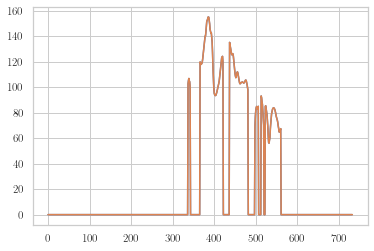

In [31]:
np.interp(np.arange(len(y_test[0][:, 0]), step=0.5), xp=np.arange(len(y_test[0][:, 0]), step=1), fp=y_test[0][:, 0])
plt.plot(np.arange(len(y_test[0][:, 0]), step=1), y_test[0][:, 0])
plt.plot(np.arange(len(y_test[0][:, 0]), step=0.5), np.interp(np.arange(len(y_test[0][:, 0]), step=0.5), xp=np.arange(len(y_test[0][:, 0]), step=1), fp=y_test[0][:, 0]))

In [ ]:
param_grid = {'hidden_layer_size': [50,100,200,400,500,800,1000,1600,2000,3200,4000,6400,8000,16000],
              'k': [0,1,2,3,4,5,6]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/km_esn_dense_" + str(params["hidden_layer_size"]) + "_" + str(params["k"]) + "_0.joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],params["k"],0,
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

In [ ]:
param_grid = {'hidden_layer_size': [50,100,200,400,500,800,1000,1600,2000,3200,4000,6400,8000,16000],
              'k': [0,1,2,3,4,5,6]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/km_esn_dense_" + str(params["hidden_layer_size"]) + "_" + str(params["k"]) + "_" + str(params["k"]) + ".joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],params["k"],params["k"],
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

In [ ]:
df1 = pd.read_csv("../f0/basic_esn_final.csv", sep=",")
df2 = pd.read_csv("../f0/km_esn_only_supervised.csv", sep=",")
df3 = pd.read_csv("../f0/km_esn_only_unsupervised.csv", sep=",")
df4 = pd.read_csv("../f0/km_esn_completely_augmented.csv", sep=",")

In [ ]:
df1["GPE"] = 100*df1["GPE"] / 2
df2["GPE"] = 100*df2["GPE"] / 2
df3["GPE"] = 100*df3["GPE"] / 2
df4["GPE"] = 100*df4["GPE"] / 2
df1["VDE"] = 100*df1["VDE"] / 2
df2["VDE"] = 100*df2["VDE"] / 2
df3["VDE"] = 100*df3["VDE"] / 2
df4["VDE"] = 100*df4["VDE"] / 2

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.5)
sns.lineplot(data=df1[df1['supervised\_st'] == 0], x="hidden\_layer\_size", y="GPE", marker="o", ax=ax)
sns.lineplot(data=df2[df2['supervised\_st'] == 0], x="hidden\_layer\_size", y="GPE", marker="o", ax=ax)
ax.set_xlim([0, 16200])
ax.tick_params(labelsize=8)
plt.legend(labels=["Basic ESN","KM-ESN"],prop={'size': 8})
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("GPE in \%", fontsize=8)
# ax.set_ylim([0, 22000])
plt.savefig('GPE_test.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.5)
sns.lineplot(data=df1[df1['supervised\_st'] == 0], x="hidden\_layer\_size", y="VDE", marker="o", ax=ax)
sns.lineplot(data=df2[df2['supervised\_st'] == 0], x="hidden\_layer\_size", y="VDE", marker="o", ax=ax)
ax.set_xlim([0, 16200])
ax.tick_params(labelsize=8)
plt.legend(labels=["Basic ESN","KM-ESN"],prop={'size': 8})
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("VDE in \%", fontsize=8)
# ax.set_ylim([0, 22000])
plt.savefig('VDE_test.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.5)
sns.lineplot(data=df1, x="hidden\_layer\_size", y="GPE", hue="supervised\_st", marker="o", ax=ax)
ax.set_xlim([0, 16200])
ax.tick_params(labelsize=8)
plt.legend(prop={'size': 8},loc='center left', bbox_to_anchor=(1.1, 0.5))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("GPE in \%", fontsize=8)
ax.set_ylim([13.5, 26])
plt.savefig('Basic_ESN_augmented_GPE.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.5)
sns.lineplot(data=df2, x="hidden\_layer\_size", y="GPE", hue="supervised\_st", marker="o", ax=ax)
ax.set_xlim([0, 16200])
ax.tick_params(labelsize=8)
plt.legend(prop={'size': 8},loc='center left', bbox_to_anchor=(1.0, 0.5))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("GPE in \%", fontsize=8)
ax.set_ylim([13.5, 20])
plt.savefig('KM_ESN_augmented_GPE.pdf', bbox_inches='tight', pad_inches=0)